<a href="https://colab.research.google.com/github/lim-jr/ESAA/blob/main/0403%EC%9B%94%EA%B3%BC%EC%A0%9C_%EC%BA%90%EA%B8%80%ED%95%84%EC%82%AC_%EA%B5%B0%EC%A7%91(kmeans%2Cdbscan%2Cap).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Kaggle : Customers clustering: K-Means, DBSCAN and AP**
(https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap/notebook)

# **1. Intorduction**

1. 계층적 알고리즘 
  * 하위 집합에 항목이 하나만 포함될 때까지 더 작은 하위 집합으로 분할 
  * 덴드로그램으로 표현
2. 분할 알고리즘 
  * 어진 기준에 따라 데이터 집합을 여러 하위 집합(클러스터)으로 나눔
  * 클러스터 수를 선행 값(예: K-평균)으로 정해야함


# **2. Reading Data**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.4.4
numpy version: 1.22.4
seaborn version: 0.12.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 
os.chdir("/content/drive/MyDrive/ESAA/데이터셋")

In [4]:
mall_data = pd.read_csv("Mall_Customers.csv")
mall_data.shape

(200, 5)

In [6]:
mall_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


* 6개 중 5개의 피처는 숫자형, 1개의 피처는 범주형(gender)

In [8]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

# **3. EDA**

## **3.1 Distribution**

age & gender 분포

In [ ]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

* 남성 고객의 평균 연령은 여성 고객(39.8 대 38.1)보다 약간 높습니다. 
* 남성 연령의 분포는 여성보다 더 균일하며, 가장 큰 연령대는 30-35세입니다.

In [10]:
stats.ks_2samp(males_age, females_age)

KstestResult(statistic=0.11525974025974026, pvalue=0.4870072659277529, statistic_location=56, statistic_sign=-1)

* p-value = 0.5 
* Kolgomorov-Smirnov 검정은 이 두 그룹 간의 차이가 통계적으로 유의하지 않음을 보여줍니다.

income & gender 분포  

<ipython-input-11-0d86fc4a2b23>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-11-0d86fc4a2b23>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_income, bins=my_bi

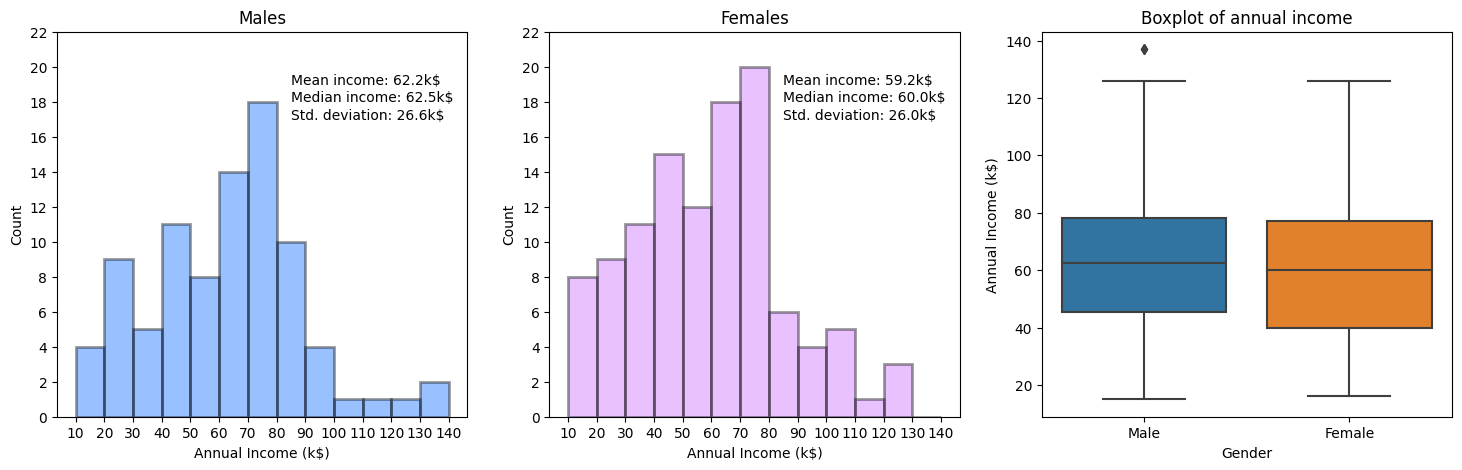

In [11]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

* 남성의 평균 소득은 여성보다 높습니다(62.2k 대 59.2k). 
* 남성 고객의 중위 소득(62.5k)은 여성 고객(60k)보다 높습니다. 
* 이상치 : 연간 수입이 약 140,000달러인 남성 그룹에 한 명의 특이한 사람이 있습니다.

In [13]:
stats.ks_2samp(males_income, females_income)

KstestResult(statistic=0.09009740259740259, pvalue=0.7781975893238194, statistic_location=70, statistic_sign=-1)

* p-value = 0.77
* K-S 검정을 통해 이 두 그룹이 통계적으로 다르지 않음을 알 수 있습니다.

spending & gender 분포  

<ipython-input-14-95f80557e0ae>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-14-95f80557e0ae>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_spending, 

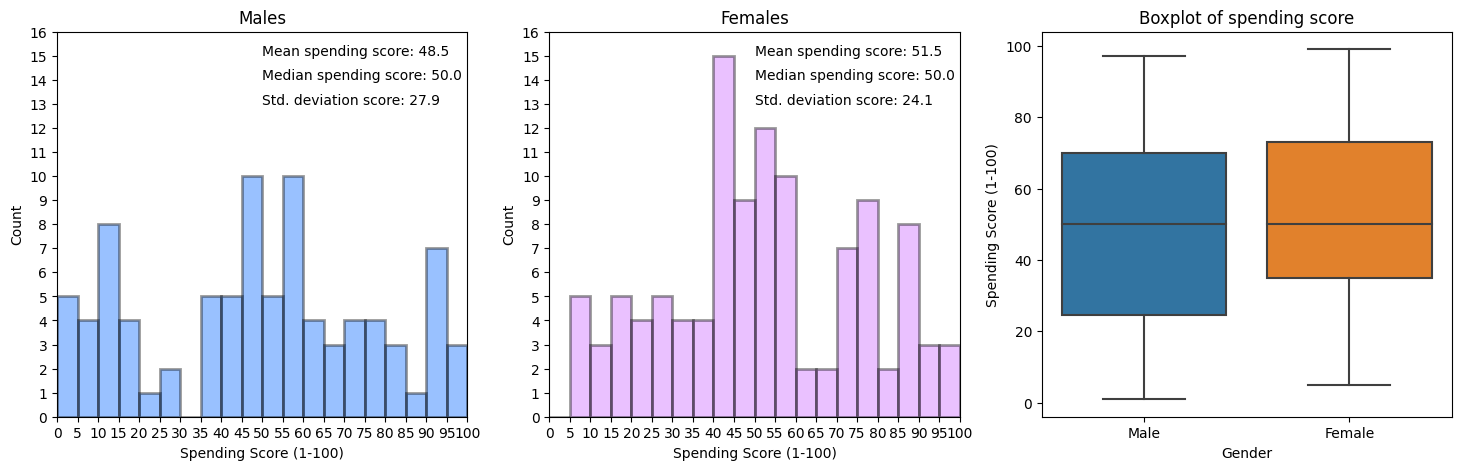

In [14]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

* 여성의 평균 지출 점수(51.5)는 남성(48.5)보다 높습니다.

In [17]:
stats.ks_2samp(males_spending, females_spending)

KstestResult(statistic=0.13555194805194806, pvalue=0.293541066935288, statistic_location=15, statistic_sign=1)

* p-value = 0.3
* K-S 검정 p-값은 귀무 가설을 기각할 증거가 없다는 것을 나타내지만, 이전의 비교처럼 증거가 강력하지는 않습니다.

median income(중위소득) & age & gender

In [27]:
medians_by_age_group = mall_data.groupby(['Gender', pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index =  medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)
medians_by_age_group

,Gender,Age_group,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
0,Female,"(15, 20]",112.0,19.0,63.0,50.0
1,Female,"(20, 25]",46.0,23.0,39.0,65.0
2,Female,"(25, 30]",139.5,29.0,74.5,73.0
3,Female,"(30, 35]",126.0,32.0,70.0,69.0
4,Female,"(35, 40]",138.5,38.0,73.5,41.0
5,Female,"(40, 45]",137.0,44.0,73.0,28.0
6,Female,"(45, 50]",82.0,49.0,54.0,44.5
7,Female,"(50, 55]",87.0,54.0,57.0,43.0
8,Female,"(55, 60]",74.0,58.0,50.0,35.0
9,Female,"(60, 65]",79.0,64.0,51.5,39.0


<Axes: xlabel='Age_group', ylabel='Annual Income (k$)'>

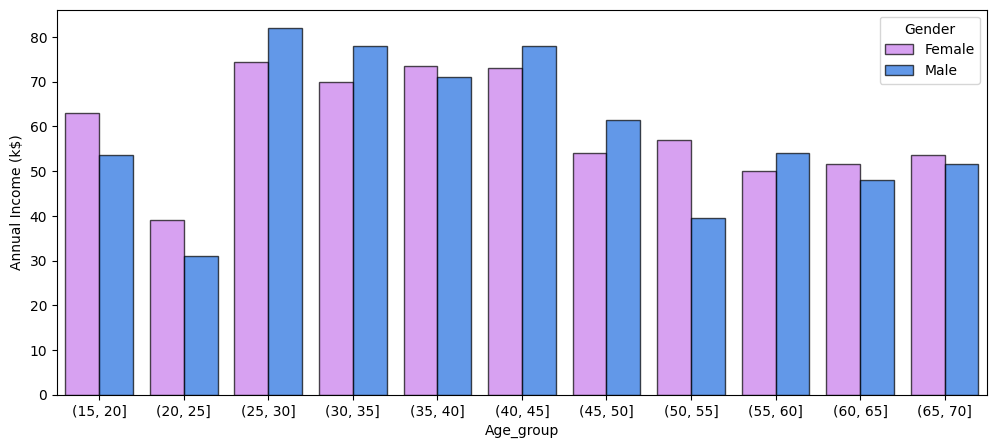

In [29]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'], alpha=0.7,edgecolor='k', ax=ax)

## **3.2 Correlations**
* 숫자형 변수 사이의 상관관계 

-0.3272268460390901


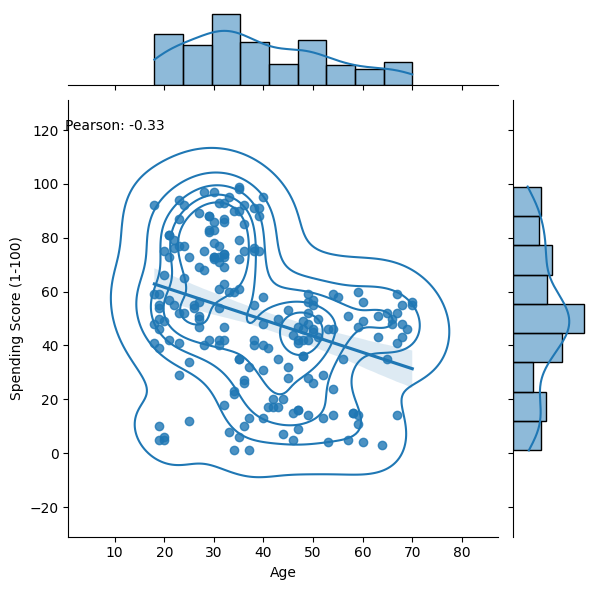

In [34]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])
print(corr)

jp = (sns.jointplot(data=mall_data, x='Age', y='Spending Score (1-100)', kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

* 나이와 지출점수 사이에 약한음의상관관계(-0.33)가 나타남

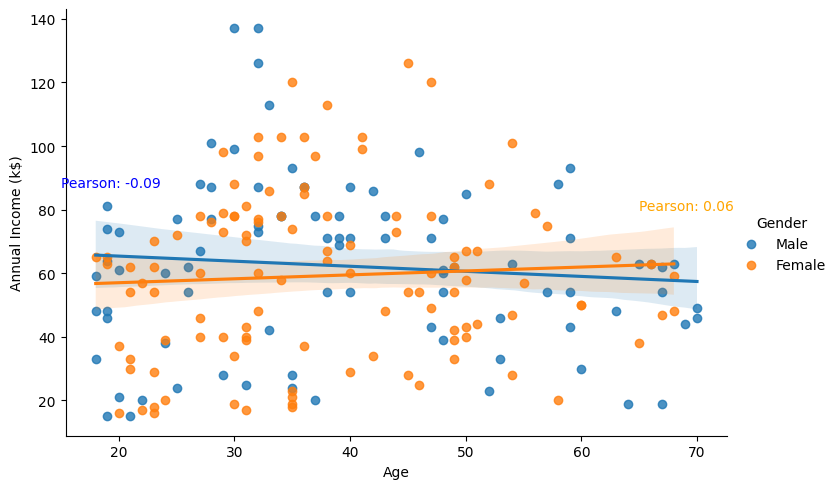

In [33]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot(data=mall_data, x='Age', y='Annual Income (k$)', hue='Gender', aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

* 두 성별 그룹 모두,   
  나이와 연간소득 사이 상관관계가 없다고 볼 수 있다.  

-0.27962764627493136
-0.37543858377804745


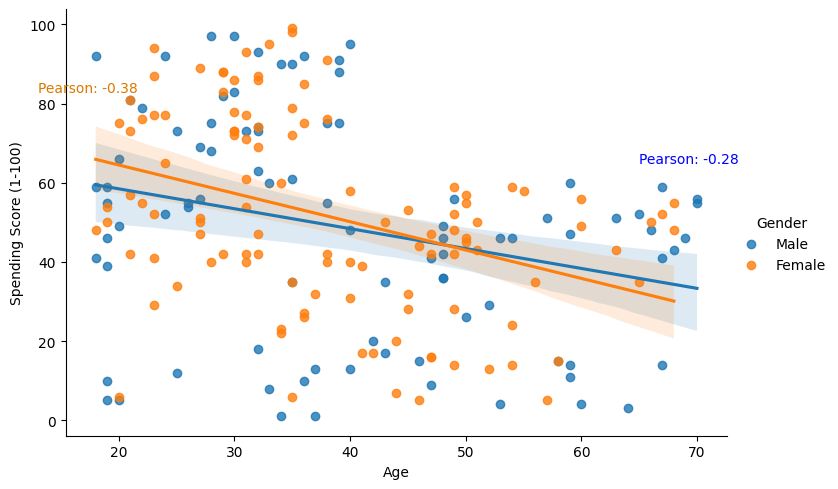

In [37]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)
print(corr1)
print(corr2)

sns.lmplot(data=mall_data, x='Age', y='Spending Score (1-100)', hue='Gender', aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

* 두 성별 그룹 모두,   
  나이와 지출 점수 사이에에 약한음의상관관계가 나타난다.

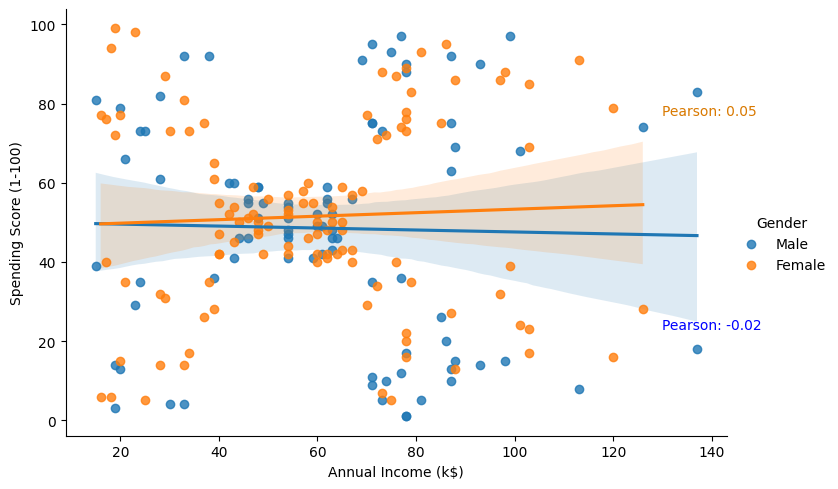

In [40]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot(data=mall_data, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender', aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

* 두 성별 그룹 모두,    
  연간소득과 지출점수는 상관관계가 없다고 볼 수 있다.  

# **4. Clustering**

## **4.1 K-means**

### **4.1.1 Description**

* K-Means 알고리즘에는 세 가지 주요 단계가 있습니다.
  1. 시드 포인트를 사용하여 샘플을 초기 그룹으로 나눕니다. 이 시드 포인트에서 가장 가까운 샘플은 초기 군집을 만듭니다.
  2. 그룹의 중심점(centroid)까지의 표본 거리를 계산하고 가장 가까운 표본을 군집에 할당합니다.
  3. 새로 생성된(업데이트된) 군집 중심을 계산합니다.   
  그런 다음 알고리즘이 수렴될 때까지 2단계와 3단계를 반복합니다.

* 일반적으로 K-Means 알고리즘의 사용자는 세 가지 주요 파라미터를 정의해야 합니다
  1. 초기화 기준 (Initialisation criteria)    
    "k-means++". 일반적으로 서로 떨어져 있는 초기 중심을 생성하여 더 나은 결과를 얻을 확률을 높입니다. 
  2. 군집 수 (Number of Clusters)
    엘보방법 / 실루엣방법
  3. distance metric (학습에는 필요하지 않음)
    점 사이의 거리를 계산하는 다양한 옵션이 있습니다. 가장 인기 있는 것은 단순히 유클리드 메트릭  

### **4.1.2 Use case - customers segmentation**

In [41]:
from sklearn.cluster import KMeans

In [44]:
# subset with numeric variables only
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
X_numerics.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


최적 클러스터 개수    
  1. 엘보 방법    

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer=KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

* 5개가 최적

2. 실루엣 방법

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

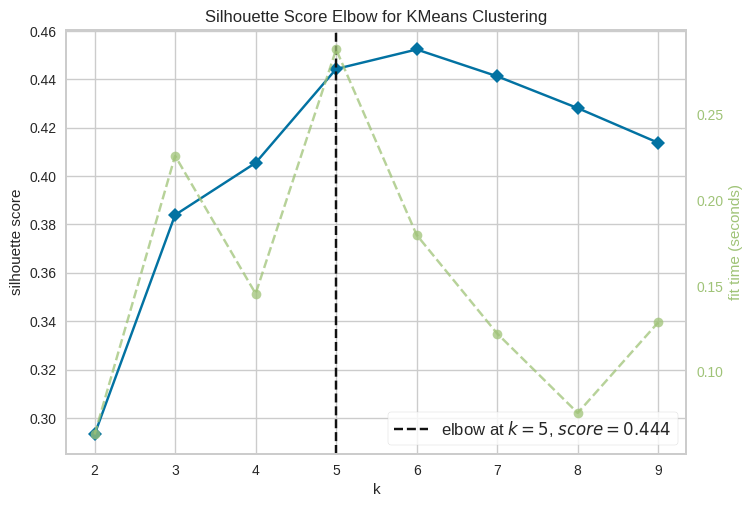

In [48]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

* 5개 or 6개가 최적

**case1) 5개의 군집개수**

In [50]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics)
KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:, 'Cluster'] = KM_5_clusters.labels_
KM5_clustered.head()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,19,15,39,4
1,21,15,81,1
2,20,16,6,4
3,23,16,77,1
4,31,17,40,4


In [53]:
# Age, Annual Income, Spending Score의 중심점
print(KM_5_clusters.cluster_centers_) 
print(KM_5_clusters.cluster_centers_[:,1])

[[40.66666667 87.75       17.58333333]
 [25.52173913 26.30434783 78.56521739]
 [43.08860759 55.29113924 49.56962025]
 [32.69230769 86.53846154 82.12820513]
 [45.2173913  26.30434783 20.91304348]]
[87.75       26.30434783 55.29113924 86.53846154 26.30434783]


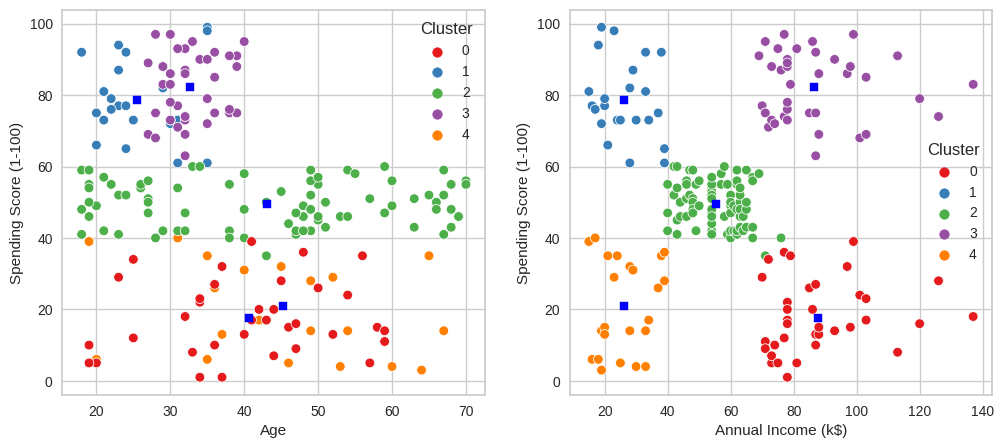

In [55]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[0], legend='full')

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[1], palette='Set1', legend='full')

# x축에 나이/연간소득, y축에 지출점수 두고 군집시각화
## 중심점이 파랑색 네모
axes[0].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

* K-평균 알고리즘은 다음 5개의 군집을 생성했습니다:
  * 나이 ~ 지출점수    
  고객 연령에 따라 구분되는 그룹이 없습니다.
  * 연간소득 ~ 지출점수  
  1. 파랑색(1) : 낮은 연간 수입과 높은 지출 점수를 가진 고객   
  2. 연두색(2) : 중간 수준의 연간 수입과 중간 수준의 지출 점수를 가진 고객   
  3. 빨강색(0) : 연간 수입이 높고 지출 점수가 낮은 고객   
  4. 보라색(3) : 연간 수입이 많고 지출 점수가 높은 고객   
  5. 주황색(4) : 낮은 연간 수입과 낮은 지출 점수를 가진 고객   



In [56]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,36
1,23
2,79
3,39
4,23


3차원 그래프

In [60]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM5_clustered['Age'],
           KM5_clustered['Annual Income (k$)'],
           KM5_clustered['Spending Score (1-100)'],
           c=KM5_clustered['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

Plotly version 

In [58]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

**case2) 6개의 군집개수**

In [62]:
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ # append labels to points

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



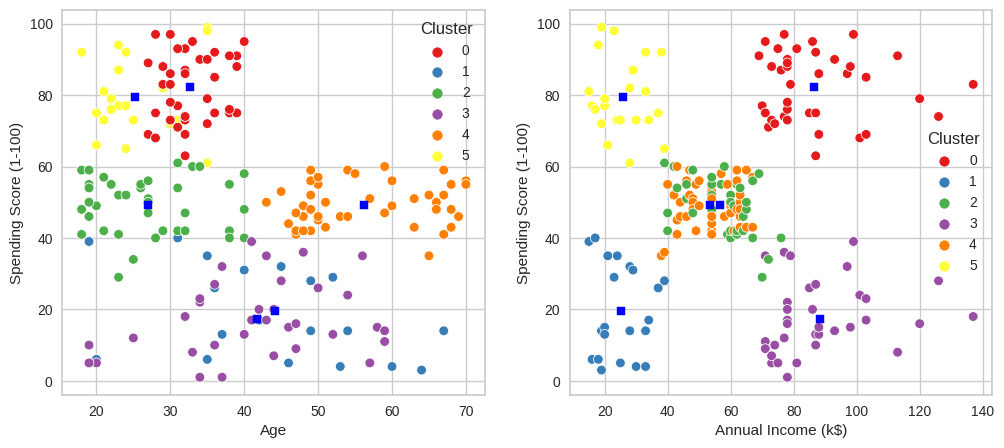

In [63]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[0], legend='full')

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[1], palette='Set1', legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

* K-평균 알고리즘은 다음 6개의 군집을 생성했습니다:
  * 나이 ~ 지출점수    
  고객 연령에 따라 구분되는 그룹이 없습니다.
  * 연간소득 ~ 지출점수  
  1. 연두색(2) : 중간 연간소득과 중간 지출점수를 받은 젊은 고객
  2. 주황색(4) : 중간 연간소득과 중간 지출점수를 받은 늙은 고객
  3. 보라색(3) : 높은 연간소득과 낮은 지출점수를 받은 고객
  4. 빨강색(0) : 높은 연간소득과 높은 지출점수를 받은 고객
  5. 파랑색(1) : 낮은 연간소득과 낮은 지출점수를 받은 고객
  6. 노랑색(5) : 낮은 연간소득과 높은 지출점수를 받은 고객  

**실루엣 다이어그램**  
: 각 군집의 품질을 확인하기 위해   
1. 수직파선이 1에 가까워야
2. 많은 덩어리(클러스터)가 수직파선을 지나쳐야
2. 모든 덩어리의 크기가 비슷해야 

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



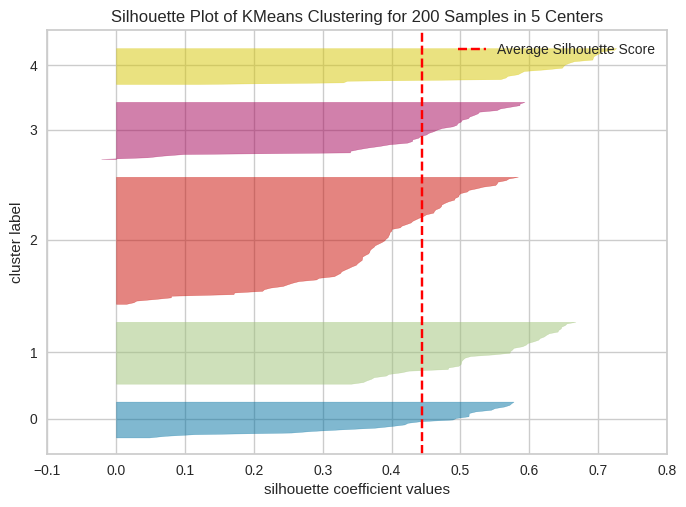

In [ ]:
# 군집개수 =5
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



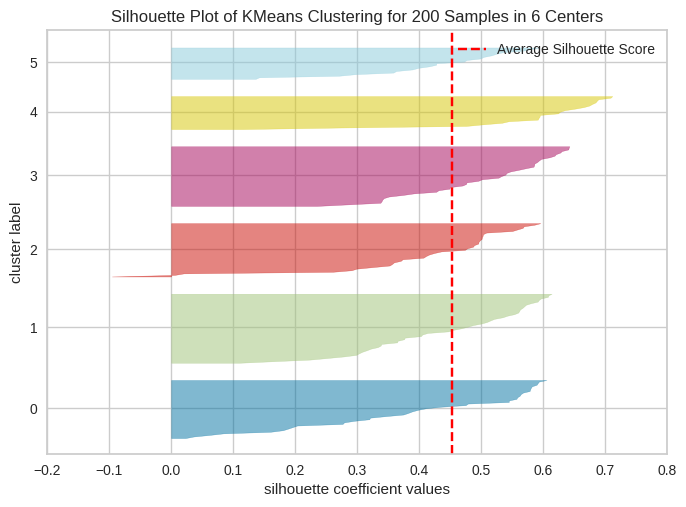

In [64]:
# 군집개수 =6
model = KMeans(n_clusters=6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

* 군집개수가 5,6일때 모두    
  수직파선의 수준이 같고, 덩어리가 수직파선을 지나친다. 
* 군집개수가 6일때가 5일때보다 덩어리의 개수가 비슷하므로    
  6개일때가 최적이라고 볼 수 있다. 

## **4.2 DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**


### **4.1.1 Description**

* Density-Based Spatial Clustering of Applications with Noise
* 이 알고리즘은 모든 클러스터가 충분히 밀집되어 있고 밀집되지 않은 지역과 잘 구분될 때 좋은 성능을 낸다.
* 2가지 파라미터
  1. Epsilon (입실론 주변 영역): 개별 데이터를 중심으로 입실론 반경을 가지는 원형의 영역입니다.
  2. Min Points(최소 데이터 개수): 개별 데이터의 입실론 주변 영역(원형)에 포함되는 타 데이터의 개수입니다. 
* 기타 용어
  1. Core Point(핵심 포인트): Eps 거리 내에 점을 MinPts만큼 가지고 있는 점을 핵심 포인트라고 합니다.

  2. Neighbor Point(이웃 포인트): Eps 거리 내에 위치한 타 데이터를 이웃 포인트라고 합니다.

  3. Bordor Point(경계 포인트): Eps 거리 내에 MinPts 이상의 이웃 포인트를 가지고 있지 않지만    
  핵심 포인트를 이웃 포인트로 가지고 있는 데이터를 경계 포인트라고 합니다.

  4. Noise Point(잡은 포인트): 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않으며, 핵심 포인트도 이웃 포인트로 가지고 있지 않는 데이터를 잡음 포인트라고 합니다.

  (https://nicola-ml.tistory.com/10)   
  (https://bcho.tistory.com/1205)


* DBSCAN의 장점  
  1. eps, MinPts 파라미터 기반으로 클러스터 개수를 정한다. 따라서 클러스터 최적 개수 정의 불필요
  2. 비선형 경계 클러스터링 가능 
  3. 이상치에 강함. 어떤 클러스터에도 해당되지 않는 점을 찾을 수 있음.

* DBSCAN의 단점
  1. 높은 계산비용
  2. 밀도가 다양한 클러스터를 제대로 식별하지 못함  

### **4.1.2 Use case - customers segmentation**

In [65]:
from sklearn.cluster import DBSCAN

It is difficult arbitrarily to say what values will work the best. Therefore, I will first create a matrix of investigated combinations.


In [71]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))
# product() : 두 개 이상의 리스트의 모든 조합을 구할 때 사용된다.
DBSCAN_params[0][0]

8.0

->질문 들어올 듯 왜이렇게 설정햇냐

설정한 파라미터를 기반으로 생성된 클러스터 확인인 

In [82]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_))) 
    # eps, min 조합마다 생성된 클러스터 레이블의, 고윳값 개수(즉 군집의개수+이상치개수)를 append
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))
    # eps, min 조합마다 생성된 클러스터의 실루엣 점수를 append

In [78]:
print(np.unique(DBS_clustering.labels_))
print(len(np.unique(DBS_clustering.labels_)))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
17


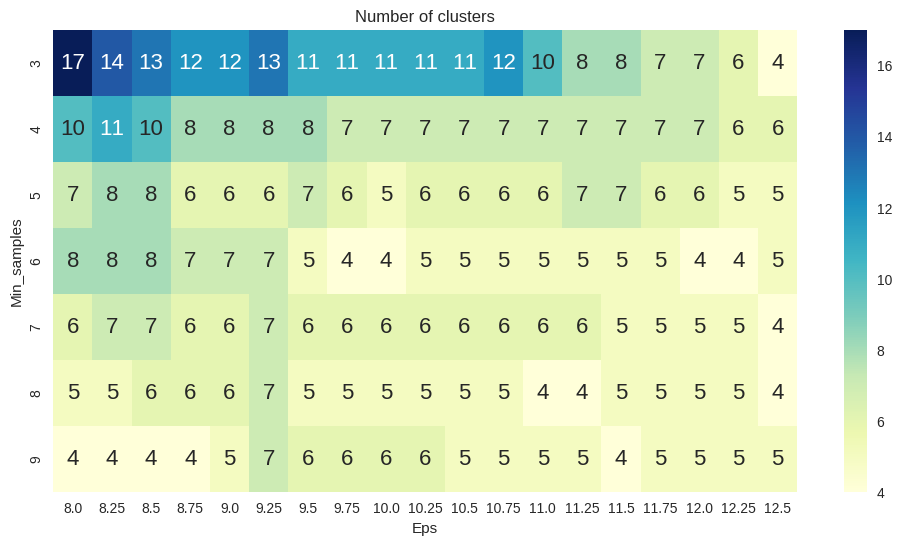

In [83]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

* 위 히트맵에서 군집의 수가 17~4개까지 다양함.
* 그러나 대부분의 조합이 4~7개 정도.  
   
어떤 조합을 선택할지 결정하기 위해 실루엣 점수를 사용해 다시 히트맵 그려본다.

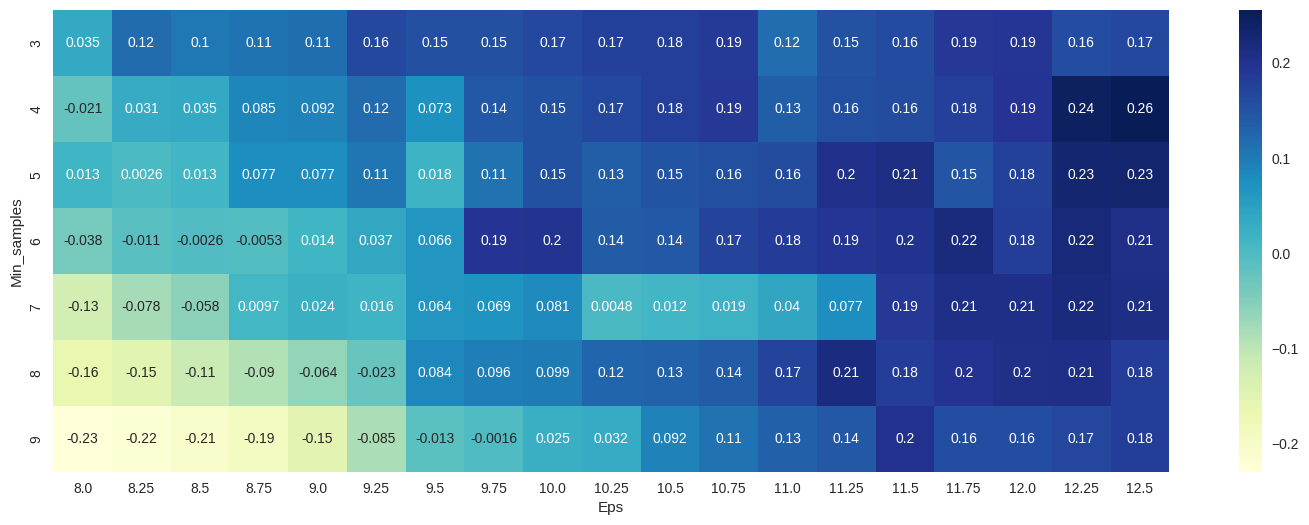

In [84]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

* Global maximum is 0.26    
  for eps=12.5 and min_samples=4.

In [85]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [86]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


* 이상치가 18개이고, 군집개수가 6개

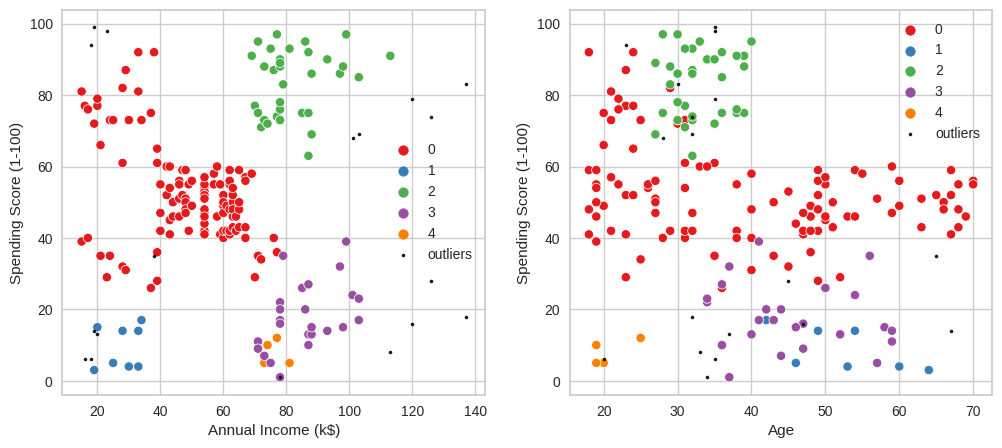

In [88]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot(x='Age', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

##**4.3 Affinity Propagation**

###**4.3.1 Description**

###**4.3.2 Use case - customers segmentation**

In [ ]:
from sklearn.cluster import AffinityPropagation

In [ ]:
no_of_clusters = []
preferences = range(-20000,-5000,100) # arbitraty chosen range
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() # display only 5 best scores

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



,preference,clusters,sil_score
82,-11800.0,6.0,0.451649
27,-17300.0,6.0,0.451491
51,-14900.0,6.0,0.451491
52,-14800.0,6.0,0.451440
28,-17200.0,6.0,0.451440


In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(preferences, af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [ ]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [ ]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [ ]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


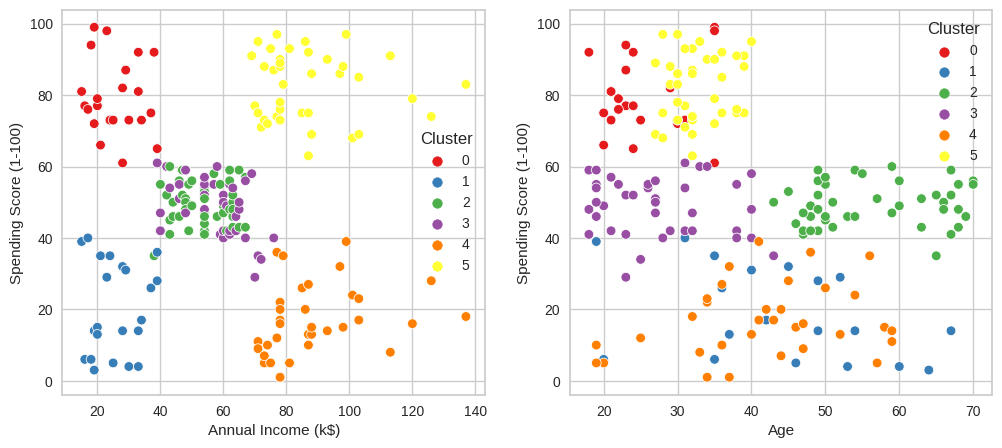

In [ ]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot( data=AF_clustered, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot(data=AF_clustered, x='Age', y='Spending Score (1-100)', 
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

# **5. Comparison and discussion**

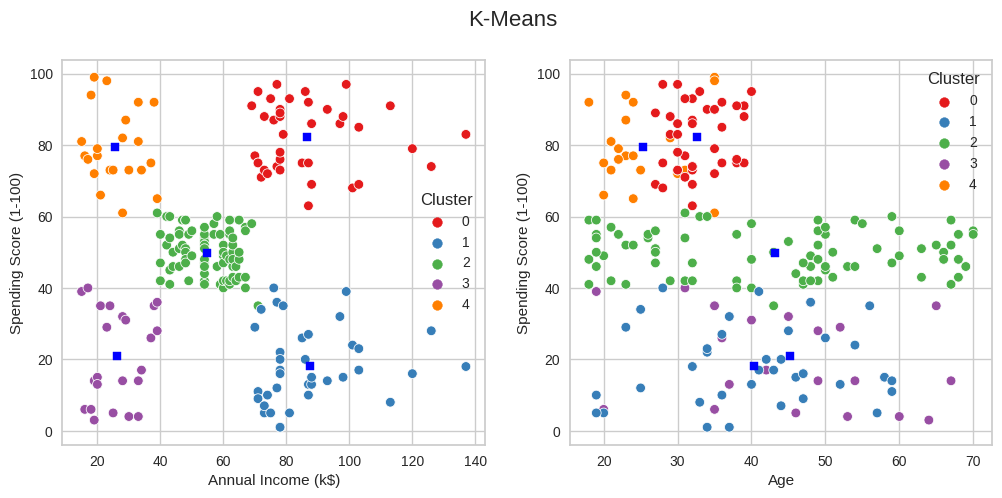

In [ ]:
fig1.suptitle('K-Means', fontsize=16)
fig1

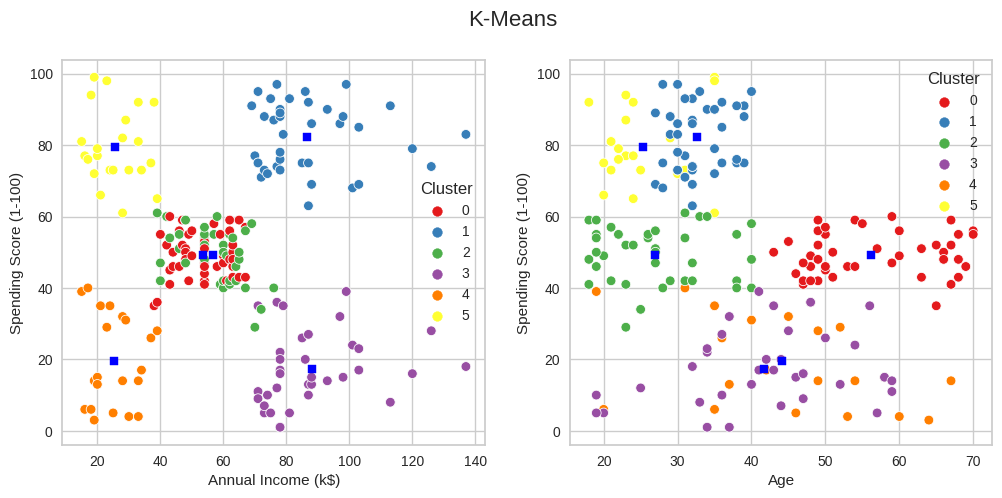

In [ ]:
fig11.suptitle('K-Means', fontsize=16)
fig11

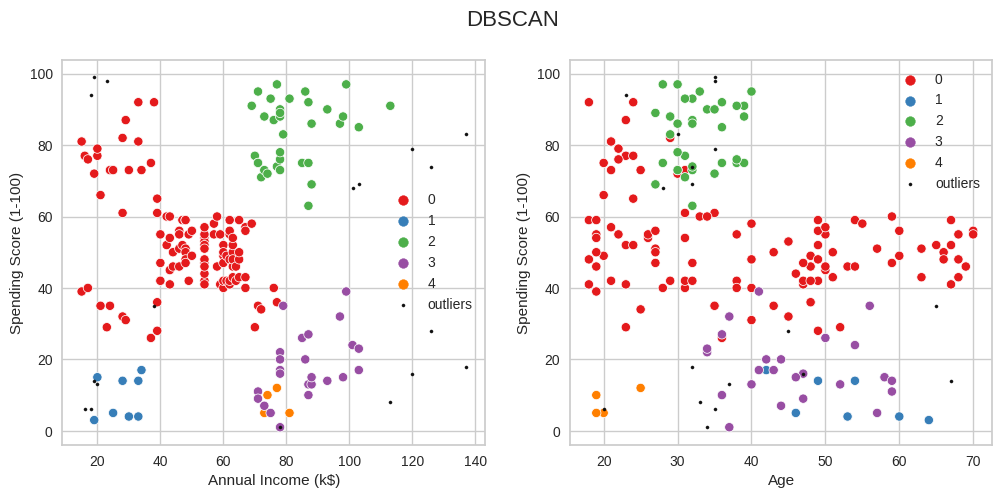

In [ ]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

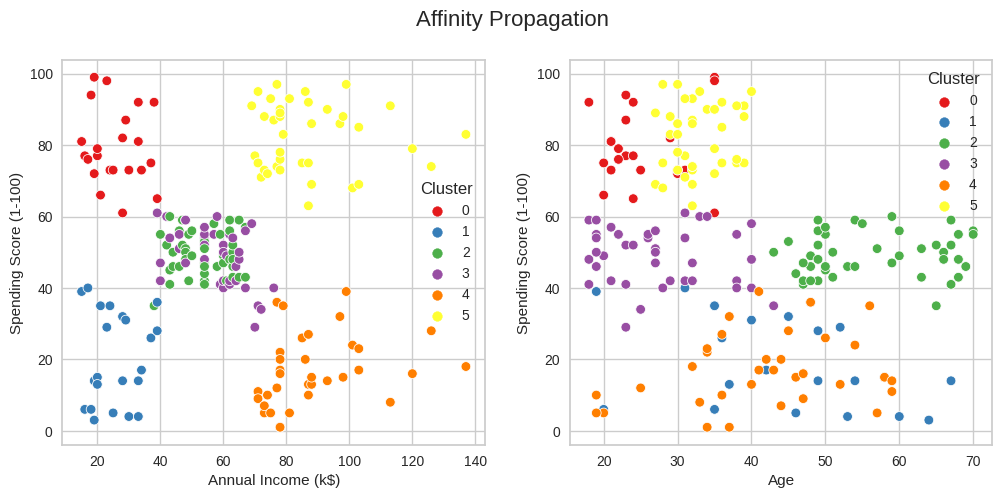

In [ ]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

In [ ]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
0,45.0,112.0,22.0
1,39.0,8.0,22.0
2,38.0,34.0,44.0
3,35.0,24.0,39.0
4,21.0,4.0,34.0
5,22.0,NaN,39.0
-1,NaN,18.0,NaN
